-----Reading XML

In [1]:
import xml.etree.ElementTree as ET

In [2]:
tree = ET.parse(r'C:\Users\cid2r\Documents\!VSCode\discogs_20220201_masters.xml')
#tree = ET.parse('rel.xml')
root = tree.getroot()

----Data Scraping

In [ ]:
pip install python3-discogs-client

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
import discogs_client

d = discogs_client.Client('ExampleApplication/0.1', user_token = 'WkcTWMWNFmwUFYHrtQIreHRnLmyFZTNnkflNHsgc')


In [4]:
import os
import urllib.request
from ast import literal_eval

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"


In [7]:
#0310추가
import requests
import shutil
#0312추가
import requests
from bs4 import BeautifulSoup
import json



for release in root.iter('master'):
    id = release.attrib.get('id')
    
    if int(id) > 462054:


        master_scarp = 'https://www.discogs.com/master/' + str(id)
        soup = BeautifulSoup(requests.get(master_scarp).text)
        rslt = soup.find('script', attrs={'id':'master_schema'})
        if rslt == None:
            continue
        else:
            json_file = json.loads(rslt.get_text())
            rating = json_file['@graph'][0]['aggregateRating']['ratingCount']
            
        standard = 1000 if 'Electronic' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            or 'Rock' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            else 150
    
        if rating >= standard:
            
            print(id)
    
            gens=[]
            for gen in release.iter('genre'):
               gens.append(gen.text)
    
            imglnk = d.master(id).images
            if(imglnk != None):
                if('uri150' in imglnk[0]):
                    uri = imglnk[0]['uri150']
    
        
            if len(gens) == 1:
                if gens[0] == 'Funk / Soul':
                    gens[0] = 'Funk&Soul'
                makedirs(os.path.join(win_dir, gens[0]))
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, ('Funk&Soul' if gens[0] == 'Funk / Soul' else gens[0]), img_name)
                #0310add
                makedirs(os.path.join(win_dir, gens[0]))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
            else:
                multi_dir = ''
                separator = '+'
                for idx, val in enumerate(gens):
                    multi_dir += ('Funk&Soul' if val == 'Funk / Soul' else val) + ('' if idx == len(gens) -1 else separator)
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, 'multi', multi_dir, img_name)
            
                makedirs(os.path.join(win_dir, 'multi',multi_dir))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
            
            

    
        if int(id) >= 499999:
            break

print("done! done!")



450314
450995
451339
451500
451522
451549
452413
452609
454164
454284
455161
455338
455343
455505
455981
456129
456220
456226
456321
456385
457164
457900
458297
458628
458843
459370
459599
459684
460009
460634
460976
461722
461758
461839
462054


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

-----현재 안쓰는 코드

In [ ]:
'''
import os

#win
#db_list = os.listdir(r"C:\Users\cid2r\Documents\!VSCode\0220dbtest\data")

#mac
db_list = os.listdir(r"/Users/cooky/Documents/GitHub/0220dbtest/data")
'''

In [ ]:
'''
import pandas as pd


alldata = []

for file in db_list:
    df = pd.read_csv(file)
    alldata.append(df)

df_0_2_100k = pd.concat(alldata, axis=0, ignore_index=True)
df_0_2_100k.to_csv("/Users/cooky/Documents/GitHub/0220dbtest/data/output", index=False)

'''


In [ ]:
df_0_2_100k = pd.read_csv("data_20k_2_25k.csv")

df_test = df_0_2_100k.copy()
df_test.drop(columns='Unnamed: 0')

In [ ]:
from ast import literal_eval


for idx,row in df_test.iterrows():
    gen_str = row['genre']
    gens = literal_eval(gen_str)
    #print(idx)
    for gen in gens:
        if gen in df_test.columns:
            df_test.at[idx, gen] = 1
        else:
            df_test[gen] = 0
            df_test.at[idx, gen] = 1

            

            

In [ ]:
pd.crosstab(df_test.Jazz, df_test.Electronic)

In [ ]:
DISCOGS_KEY = 'OKxXReJmUJvMJRRsaOqr'
DISCOGS_SECRET = 'RormADbxpiujDCXDiBDwFGUFxKrVjkTK'

----실험실

In [3]:
import torch

torch.cuda.is_available()

True

In [51]:
#win
#pip install fastai

#mac
! conda install -c fastai fastai

^C


In [15]:

macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"

BATCH_SIZE = 32
IMG_HEI = 224
IMG_WID = 224

In [5]:
import pathlib

dat_dir = pathlib.Path(win_dir)
cnt = len(list(dat_dir.glob('*/*.jpeg')))
print(cnt)

6998


In [6]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image




In [44]:
print(tf.__version__)

2.8.0


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dat_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEI, IMG_WID),
    batch_size=BATCH_SIZE
)

Found 6998 files belonging to 14 classes.
Using 5599 files for training.


In [46]:
lb = np.concatenate([y for x, y in train_ds], axis = 0)


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEI, IMG_WID),
  batch_size=BATCH_SIZE)

Found 6998 files belonging to 14 classes.
Using 1399 files for validation.


In [48]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=67>

In [15]:
class_names = train_ds.class_names
print(class_names)

['Blues', "Children's", 'Classical', 'Electronic', 'Folk, World, & Country', 'Funk&Soul', 'Hip Hop', 'Jazz', 'Latin', 'Non-Music', 'Pop', 'Reggae', 'Rock', 'Stage & Screen']


In [127]:
def wcount(num):
    return (1 / num) * (6373/13)

In [128]:
class_weight = {
    0 : wcount(43),
    1 : wcount(47),
    2 : wcount(454),
    3 : wcount(117),
    4 : wcount(1354),
    5 : wcount(1357),
    6 : wcount(810),
    7 : wcount(17),
    8 : wcount(14),
    9 : wcount(334),
    10 : wcount(254),
    11 : wcount(1531),
    12 : wcount(41)
}

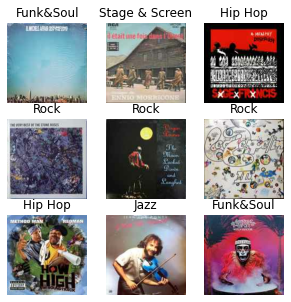

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [204]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
lb = np.concatenate([y for x, y in train_ds], axis = 0)

In [10]:
from tensorflow.keras import layers

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0040779863 0.9241949


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
num_classes = 13

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEI, IMG_WID, 3)),
  layers.Conv2D(224, 64, padding='same', activation='relu'),
  layers.Conv2D(224, 64, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(112, 128, padding='same', activation='relu'),
  layers.Conv2D(112, 128, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(56, 256, padding='same', activation='relu'),
  layers.Conv2D(56, 256, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(14, 512, padding='same', activation='relu'),
  layers.Conv2D(14, 512, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(num_classes)
])

ResourceExhaustedError: OOM when allocating tensor with shape[64,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [33]:
model.compile(optimizer='sgd', loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs =10


with tf.device("/device:GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEI, 
                                                              IMG_WID,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [118]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight(
    'balanced',np.unique(train_ds.class_names)
    ,train_ds.class_names
)

print(class_weight)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\cid2r\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['Blues' 'Classical' 'Electronic' 'Folk, World, & Country' 'Funk&Soul'
 'Hip Hop' 'Jazz' 'Latin' 'Non-Music' 'Pop' 'Reggae' 'Rock'
 'Stage & Screen' 'models' 'multi'], y=['Blues', 'Classical', 'Electronic', 'Folk, World, & Country', 'Funk&Soul', 'Hip Hop', 'Jazz', 'Latin', 'Non-Music', 'Pop', 'Reggae', 'Rock', 'Stage & Screen', 'models', 'multi'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [158]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))

In [156]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [246]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet')

In [248]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [233]:
print(class_weight)

{0: 11.40071556350626, 1: 10.430441898527004, 2: 1.0798034564554388, 3: 4.190006574621959, 4: 0.3620611294171117, 5: 0.3612606995068307, 6: 0.6052231718898385, 7: 28.83710407239819, 8: 35.01648351648351, 9: 1.4677567941040996, 10: 1.9300423985463355, 11: 0.3202029844747023, 12: 11.956848030018762}


In [249]:
epochs = 5

with tf.device("/device:GPU:0"):
    history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


C:\Users\cid2r\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


KeyboardInterrupt: 

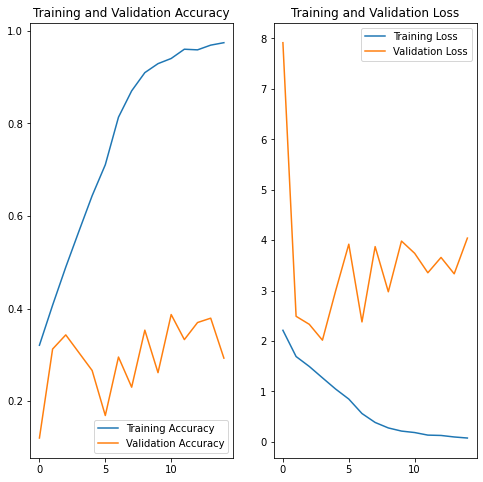

In [212]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [213]:
prob = tf.keras.Sequential([model,
                            tf.keras.layers.Softmax()])

pred = prob.predict(val_ds, verbose=2)


type(val_ds)

20/20 - 3s - 3s/epoch - 153ms/step


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [214]:
y_train = np.concatenate([y for x, y in val_ds], axis = 0)


In [215]:
np.argmax(pred, axis=1)


array([ 4,  2, 10, ...,  4,  4, 10], dtype=int64)

In [216]:

#y_train = tf.data.Dataset.from_tensor_slices(list(val_ds))


confusion = tf.math.confusion_matrix(
    labels = y_train,
    predictions=np.argmax(pred, axis=1),
    num_classes=13
)

print(confusion)

tf.Tensor(
[[ 0  0  2  0  1  0  0  0  0  1  4  4  0]
 [ 0  0  3  0  2  0  2  0  0  1  2  1  0]
 [ 3  0 19  0 19  6  2  0  0  2 15 17  0]
 [ 0  0  2  0  5  0  0  0  0  0  6  5  0]
 [ 5  2 43  0 43 37 12  0  0  9 59 61  0]
 [ 3  0 42  0 46 25 12  0  0 10 78 60  0]
 [ 6  1 28  0 33 12  6  0  0  5 44 36  0]
 [ 0  0  0  0  2  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  1  0  0  0  0  1  0  0]
 [ 1  0  6  0 12  3  2  0  0  2 19 16  0]
 [ 0  0  6  0  9  3  1  1  0  5 12 11  0]
 [ 4  1 53  0 55 31 18  0  0  8 68 67  0]
 [ 1  0  3  0  1  1  0  0  0  0  3  2  0]], shape=(13, 13), dtype=int32)


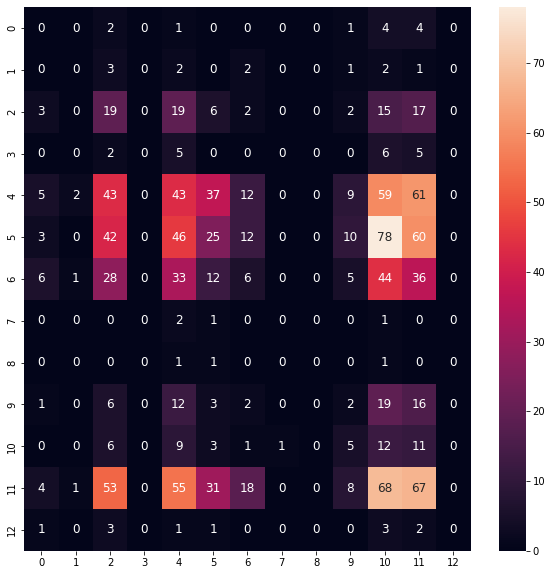

In [217]:
import seaborn as sns
import pandas as pd

cm = pd.DataFrame(confusion.numpy(),
                  range(num_classes),
                  range(num_classes))

plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={'size': 12})
plt.show()

In [140]:
for i in range(13):
    print(class_names[i])



Blues
Classical
Electronic
Folk, World, & Country
Funk&Soul
Hip Hop
Jazz
Latin
Non-Music
Pop
Reggae
Rock
Stage & Screen


In [120]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

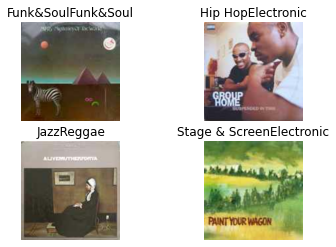

In [224]:
for images, labels in train_ds.take(1):
    for i in range(4):
        ax=plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]] + class_names[np.argmax(pred[i])]
)
        plt.axis('off')
